# OTExplainer: Gaussian Optimal Transport

This tutorial provides a deep dive into the `OTExplainer`, which uses Gaussian optimal transport for computing feature importance.

## What You'll Learn

1. Mathematical foundation of Gaussian OT
2. Key hyperparameters and their effects
3. When to use OTExplainer vs other methods
4. Best practices for real-world usage

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fdfi.explainers import OTExplainer

np.random.seed(42)

## Mathematical Background

The key insight of OTExplainer is to use the **Gaussian optimal transport map** to create counterfactual distributions.

Given data $X$ with mean $\mu$ and covariance $\Sigma$, we compute:

$$Z = L^{-1}(X - \mu)$$

where $\Sigma = LL^T$ (Cholesky decomposition). In Z-space, features are uncorrelated.

To measure the importance of feature $j$, we:
1. Replace $Z_j$ with an independent sample from $N(0, 1)$
2. Transform back to X-space
3. Compare model outputs

## Setup: Create Correlated Data

Let's create data with correlated features to see how OTExplainer handles dependencies:

In [2]:
# Create covariance matrix with correlations
n_features = 5
correlation = 0.7

cov_matrix = np.eye(n_features)
cov_matrix[0, 1] = cov_matrix[1, 0] = correlation  # Features 0 and 1 are correlated
cov_matrix[2, 3] = cov_matrix[3, 2] = correlation  # Features 2 and 3 are correlated

# Generate correlated data
n_samples = 500
X_train = np.random.multivariate_normal(
    mean=np.zeros(n_features),
    cov=cov_matrix,
    size=n_samples
)

print("Correlation matrix of training data:")
print(np.corrcoef(X_train.T).round(2))

Correlation matrix of training data:
[[ 1.    0.71 -0.03 -0.   -0.05]
 [ 0.71  1.    0.02  0.03 -0.06]
 [-0.03  0.02  1.    0.72 -0.02]
 [-0.    0.03  0.72  1.   -0.  ]
 [-0.05 -0.06 -0.02 -0.    1.  ]]


In [3]:
# Create model: only feature 0 matters
def model(X):
    return X[:, 0] ** 2

# Test data
X_test = np.random.multivariate_normal(
    mean=np.zeros(n_features),
    cov=cov_matrix,
    size=50
)

## Effect of nsamples

The `nsamples` parameter controls Monte Carlo variance. Let's see its effect:

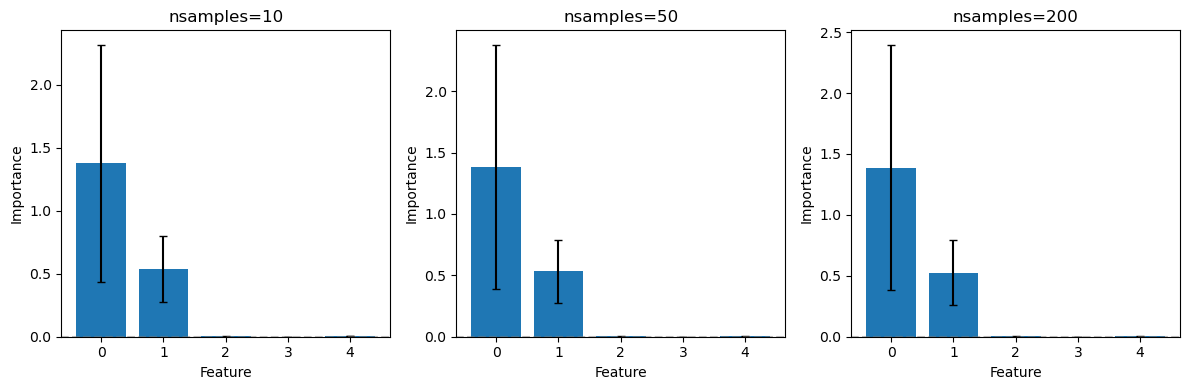

In [4]:
# Compare different nsamples values
nsamples_values = [10, 50, 200]
results_by_nsamples = {}

for ns in nsamples_values:
    explainer = OTExplainer(model, data=X_train, nsamples=ns)
    results_by_nsamples[ns] = explainer(X_test)

# Plot comparison
fig, axes = plt.subplots(1, len(nsamples_values), figsize=(12, 4))
for ax, ns in zip(axes, nsamples_values):
    phi = results_by_nsamples[ns]["phi_X"]
    se = results_by_nsamples[ns]["se_X"]
    
    ax.bar(range(n_features), phi, yerr=1.96*se, capsize=3)
    ax.set_xlabel("Feature")
    ax.set_ylabel("Importance")
    ax.set_title(f"nsamples={ns}")
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Key observation**: Higher `nsamples` gives smaller error bars (lower variance) but takes longer to compute.

## Effect of sampling_method

OTExplainer supports three sampling methods for counterfactual generation:

In [5]:
# Compare sampling methods
sampling_methods = ["resample", "permutation", "normal"]
results_by_method = {}

for method in sampling_methods:
    explainer = OTExplainer(
        model, 
        data=X_train, 
        nsamples=100,
        sampling_method=method
    )
    results_by_method[method] = explainer(X_test)

# Compare results
print("Feature importance by sampling method:")
print("-" * 50)
print(f"{'Feature':>8}", end="")
for method in sampling_methods:
    print(f"{method:>12}", end="")
print()
print("-" * 50)

for i in range(n_features):
    print(f"{i:>8}", end="")
    for method in sampling_methods:
        phi = results_by_method[method]["phi_X"][i]
        print(f"{phi:>12.4f}", end="")
    print()

Feature importance by sampling method:
--------------------------------------------------
 Feature    resample permutation      normal
--------------------------------------------------
       0      1.3690      1.3081      1.3115
       1      0.5196      0.5108      0.5431
       2      0.0020      0.0020      0.0019
       3      0.0003      0.0003      0.0003
       4      0.0030      0.0029      0.0030


**Sampling methods explained:**

- `resample`: Sample from the background data (preserves marginal distribution)
- `permutation`: Permute values within test set (no new values introduced)
- `normal`: Sample from standard normal (strongest Gaussian assumption)

## Visualizing the Z-space Transformation

Let's visualize how OTExplainer transforms correlated data to uncorrelated Z-space:

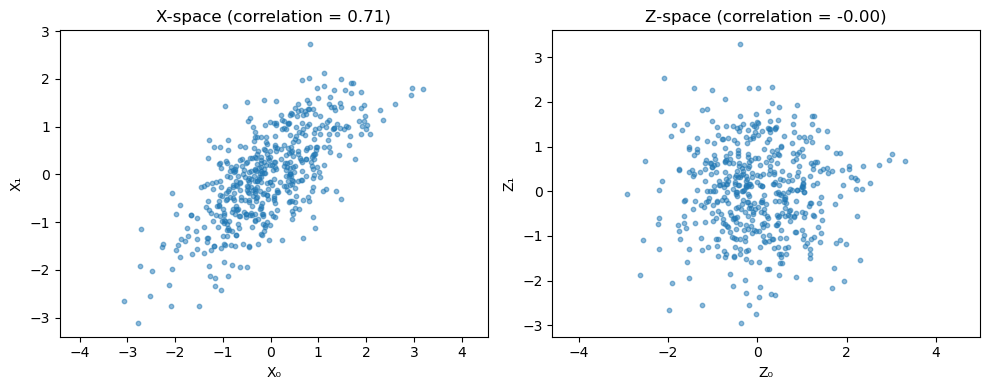

In [6]:
# Create explainer and access internal matrices
explainer = OTExplainer(model, data=X_train, nsamples=50)

# Transform to Z-space
Z_train = (X_train - explainer.mean) @ explainer.L_inv

# Plot X-space vs Z-space
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# X-space (correlated)
axes[0].scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, s=10)
axes[0].set_xlabel("X₀")
axes[0].set_ylabel("X₁")
axes[0].set_title(f"X-space (correlation = {np.corrcoef(X_train[:, 0], X_train[:, 1])[0, 1]:.2f})")
axes[0].axis('equal')

# Z-space (uncorrelated)
axes[1].scatter(Z_train[:, 0], Z_train[:, 1], alpha=0.5, s=10)
axes[1].set_xlabel("Z₀")
axes[1].set_ylabel("Z₁")
axes[1].set_title(f"Z-space (correlation = {np.corrcoef(Z_train[:, 0], Z_train[:, 1])[0, 1]:.2f})")
axes[1].axis('equal')

plt.tight_layout()
plt.show()

## Best Practices

### When to use OTExplainer

✅ **Good for:**
- Continuous features
- Roughly Gaussian data
- Fast computation
- Stable results

❌ **Consider EOTExplainer for:**
- Heavily non-Gaussian data
- Multimodal distributions
- Mixed categorical/continuous features

### Recommended settings

```python
explainer = OTExplainer(
    model,
    data=X_train,
    nsamples=50,               # Good balance of speed/accuracy
    sampling_method="resample", # Preserves marginal distribution
)
```

## Summary

Key takeaways:

1. OTExplainer uses Gaussian OT to disentangle correlated features
2. Higher `nsamples` reduces variance at the cost of computation time
3. `sampling_method="resample"` is recommended for most cases
4. The transformation to Z-space removes correlations for clean attribution